<a href="https://colab.research.google.com/github/ElPapi42/data-fresh/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount gdrive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Copy csv to notebook runtime storage
!cp '/content/drive/MyDrive/Datasets/bitcoin_price.csv' '/content/bitcoin_price.csv'

In [85]:
from datetime import datetime

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Disable decimals for this notebook
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# Load the dataset
btc = pd.read_csv('/content/bitcoin_price.csv')

In [5]:
# Preprocess MarketCap and volume from str to numeric type

btc['Market Cap'] = btc['Market Cap'].map(lambda x: int(x.replace(',', '')))

def cast_volume(value):
    """Casts a str volume to int safely."""
    value = value.replace(',', '')

    if not value.isdigit():
        return None

    return int(value)

btc['Volume'] = btc['Volume'].map(cast_volume)

btc['Date'] = pd.to_datetime(btc['Date'])

btc = btc.set_index('Date')

btc = btc[::-1]

btc = btc.reindex()

btc.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.300,135.980,132.100,134.210,nan,1500520000
2013-04-29,134.440,147.490,134.000,144.540,nan,1491160000
2013-04-30,144.000,146.930,134.050,139.000,nan,1597780000
2013-05-01,139.000,139.890,107.720,116.990,nan,1542820000
2013-05-02,116.380,125.600,92.280,105.210,nan,1292190000


In [6]:
btc.dtypes

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap      int64
dtype: object

In [7]:
btc.describe(datetime_is_numeric=True)

,Open,High,Low,Close,Volume,Market Cap
count,1760.000,1760.000,1760.000,1760.000,1517.000,1760.000
mean,1479.574,1536.991,1418.251,1485.747,995277049.848,23814544563.068
std,2950.457,3092.950,2780.859,2959.265,2989273963.629,49711849959.539
min,68.500,74.560,65.530,68.430,2857830.000,779255000.000
25%,274.730,279.857,268.640,274.875,22832500.000,3890227500.000
50%,480.715,495.195,472.510,482.810,56122400.000,6840475000.000
75%,870.085,900.222,831.683,871.370,203559000.000,12502025000.000
max,19475.800,20089.000,18974.100,19497.400,23840900000.000,326141000000.000


We have Data from 2013 to 2018

In [8]:
# Check for null values across the dataframe
btc.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume        243
Market Cap      0
dtype: int64

Volume has some missing values, possible unparseable strings

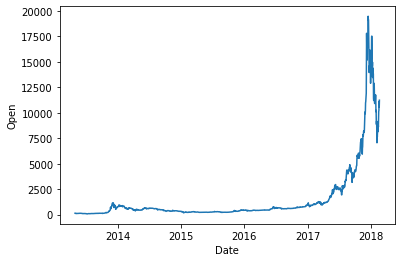

In [9]:
sn.lineplot(data=btc, x=btc.index, y='Open')

BTC Price started to boom at 2017 Q2

lets review closely the 2017 pump

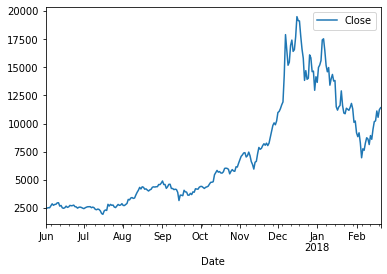

In [10]:
btc['2017-06':].plot(y=['Close'], kind='line')

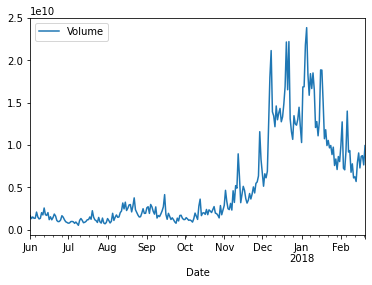

In [11]:
btc['2017-06':].plot(y=['Volume'], kind='line')

Seems that transactions volume and market price are correlated, lets find how much

In [12]:
close_pct = btc['Close']['2014':]
close_pct = (close_pct - close_pct.min()) / (close_pct.max() - close_pct.min())
close_pct = close_pct.rolling(window=180).mean().pct_change()

volume_pct = btc['Volume']['2014':]
volume_pct = (volume_pct - volume_pct.min()) / (volume_pct.max() - volume_pct.min())
volume_pct = volume_pct.rolling(window=180).mean().pct_change()

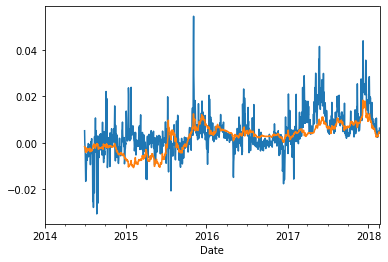

In [13]:
volume_pct.plot(kind='line')
close_pct.plot(kind='line')

In [14]:
close_pct.corr(volume_pct)

0.5329615258736072

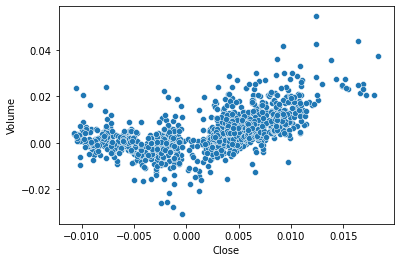

In [15]:
sn.scatterplot(x=close_pct, y=volume_pct)

We can a see a light correlation between transaction volume and price

Lets see how many days the price close higher than open

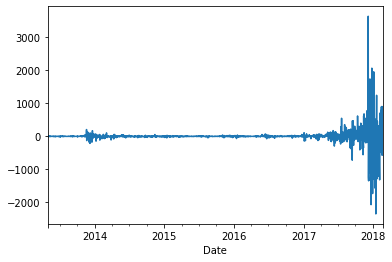

In [36]:
daily_diff = btc['Close'] - btc['Open']
daily_diff.plot()

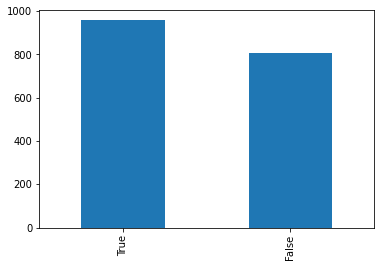

In [47]:
(daily_diff > 0).value_counts().plot(kind='bar')

The btc market usually opens the same amount of times that closes. This can give better insight if we weight the opens/closes, lets see

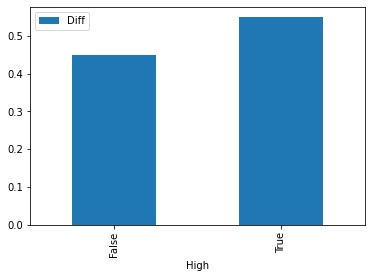

In [99]:
btc_diff = pd.DataFrame()
btc_diff['Diff'] = daily_diff
btc_diff['High'] = daily_diff > 0.0
btc_diff = btc_diff.groupby(btc_diff['High']).sum()
btc_diff = btc_diff.transform(lambda x: abs(x) / abs(daily_diff).sum())
btc_diff.plot(kind='bar')

We can observe daily price historic increase volume if slighltly higher than the decrease volume, we can say this is meaningless